Number of data points in the interval: 10969


c:\Users\fanek\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\fanek\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\fanek\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\fanek\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\fanek\anaconda3\lib\site-

SARIMA Summary:
                                       SARIMAX Results                                       
Dep. Variable:                                     y   No. Observations:                 7678
Model:             SARIMAX(0, 0, 3)x(1, 0, [1], 168)   Log Likelihood                5811.280
Date:                               Sun, 26 Jan 2025   AIC                         -11604.560
Time:                                       20:24:48   BIC                         -11542.045
Sample:                                            0   HQIC                        -11583.118
                                              - 7678                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
hour          -0.0004      0.002     -0.224      0.823      -0.004       0

c:\Users\fanek\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[]

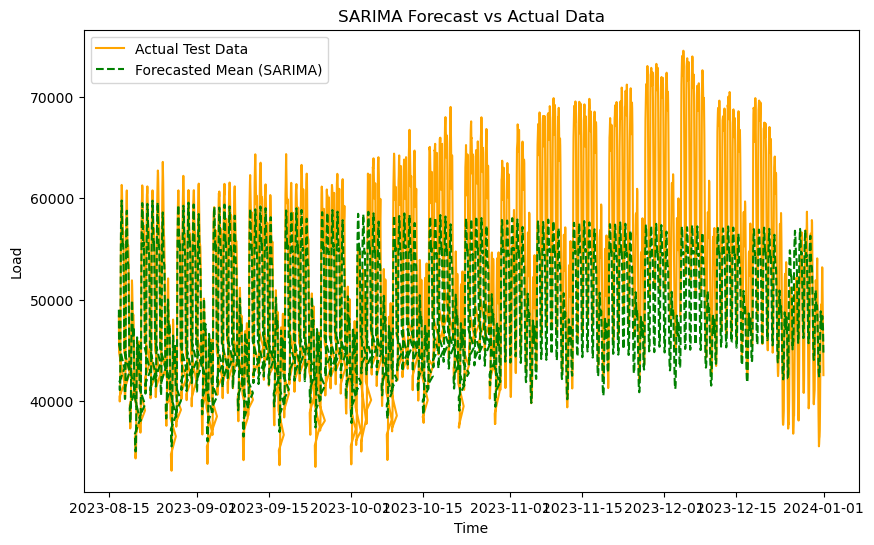

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load CSV file
file_path = r"C:\Users\fanek\...\de_hourly_energy_load.csv" # Use the avg_hourly_processed_data_with_features found in the Data file
daily_df = pd.read_csv(file_path, parse_dates=['time'], dayfirst=True)

# To convert 'time' column to datetime and set as index
daily_df['time'] = pd.to_datetime(daily_df['time'])
daily_df.set_index('time', inplace=True)

# A´To add new features to capture seasonal effects
daily_df['hour'] = daily_df.index.hour  # Extract hour of the day
daily_df['dayofweek'] = daily_df.index.dayofweek  # Extract day of the week (0=Monday, 6=Sunday)
daily_df['is_weekend'] = daily_df['dayofweek'] >= 5  # Boolean for weekends (Saturday/Sunday)

# To capture of holiday effects
holidays = ['2022-12-25', # Holidays for 2022
            '2023-01-01', '2023-12-25']  # Holidays for 2023

daily_df['is_holiday'] = daily_df.index.date.astype(str)  # Convert to a string format
daily_df['is_holiday'] = daily_df['is_holiday'].isin(holidays) 

# To convert boolean columns to 1 and 0
daily_df['is_weekend'] = daily_df['is_weekend'].astype(int)
daily_df['is_holiday'] = daily_df['is_holiday'].astype(int)

# Take a subset of the data
daily_df_subset = daily_df.loc['2022-10-01':'2023-12-31', ['load', 'hour', 'is_weekend', 'is_holiday']]
# To count the number of data points in the subset
num_data_points = daily_df_subset.shape[0]
print(f"Number of data points in the interval: {num_data_points}")


# To define training and testing datasets
train_data = daily_df_subset['load'][:7678]  
test_data = daily_df_subset['load'][7678:]  

# To standardize the data (Reshaping required for StandardScaler)
scaler = StandardScaler()

# Tocorrect reshaping: transform into 2D array for StandardScaler
scaled_train_data = scaler.fit_transform(train_data.values.reshape(-1, 1)).flatten()
scaled_test_data = scaler.transform(test_data.values.reshape(-1, 1)).flatten()

# These were found to be the optimal model parameters based on previous ARIMA output
p, d, q = 0, 0, 3
P, D, Q, s = 1, 0, 1, 24*7 

# To fit the SARIMA model with external regressors (using the training data)
mod = SARIMAX(
    scaled_train_data, 
    order=(p, d, q), 
    seasonal_order=(P, D, Q, s), 
    exog=daily_df_subset[['hour', 'is_weekend', 'is_holiday']][:7678]  # The external regressors for training data
)
sarima_result = mod.fit(disp=False)

# Print SARIMA model summary
print("SARIMA Summary:")
print(sarima_result.summary())

# To forecast with SARIMA
forecast = sarima_result.get_forecast(steps=len(scaled_test_data), exog=daily_df_subset[['hour', 'is_weekend', 'is_holiday']][7678:]) # made another change here
forecast_mean = forecast.predicted_mean

# To rescale SARIMA forecast mean to original scale
forecast_mean_rescaled = scaler.inverse_transform(forecast_mean.values.reshape(-1, 1)).flatten()

# To rescale actual test data
test_rescaled = scaler.inverse_transform(scaled_test_data.reshape(-1, 1)).flatten()

# Plot forecast vs actual data
plt.figure(figsize=(10, 6))
plt.plot(test_data.index, test_rescaled, label='Actual Test Data', color='orange')
plt.plot(test_data.index, forecast_mean_rescaled, label='Forecasted Mean (SARIMA)', color='green', linestyle='--')
plt.title('SARIMA Forecast vs Actual Data')
plt.xlabel('Time')
plt.ylabel('Load')
plt.legend()
# plt.savefig('sarima_forecast_vs_actual.png')
plt.plot()

In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
#mse_train = mean_squared_error(test_rescaled, forecast_mean_rescaled)
mse_test = mean_squared_error(test_rescaled, forecast_mean_rescaled)
#mape_train = mean_absolute_percentage_error(test_rescaled, forecast_mean_rescaled)
mape_test = mean_absolute_percentage_error(test_rescaled, forecast_mean_rescaled)

#print("Training Mean Squared Error (MSE):", mse_train)
#print("Training Mean Absolute Percentage Error (MAPE):", mape_train)
print("Testing Mean Squared Error (MSE):", mse_test)
print("Testing Mean Absolute Percentage Error (MAPE):", mape_test)

Testing Mean Squared Error (MSE): 43832667.5863975
Testing Mean Absolute Percentage Error (MAPE): 0.08403851076598194
